# Random Forest Classifier Juypter Notebook File
### Used for predicting protein enrichment [1] or depletion [0]

1. **Mount Google Drive** (if using Colab Notebooks), or download entire repository with data files

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import statements

In [6]:
!pip install biopython # otherwise the data_prep_functions will not be imported!
!pip install scikit-learn==1.5.2

In [7]:
from google.colab import drive
import os
import sys

drive.mount('/content/drive', force_remount=True)
data_prep_path = '/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/'
sys.path.append(data_prep_path)

from data_prep_functions import *

import threading
import pandas as pd
import numpy as np
import seaborn as sns
import pprint
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, classification_report, r2_score, confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.feature_selection import RFE, RFECV, f_classif
import shap

Mounted at /content/drive


### Link to proteomic data file

In [8]:
# final product after Data_Consolidation.ipynb
excel_files = ['/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Input_DataFrames/df_Bov Swiss Intensity_v1.xlsx']

Find smallest value in 'Abundance_Controls' column, use to replace any instance of zero in column. Save to 'post_clean_up_dfs' folder.

In [9]:
for file in excel_files:

    df = pd.read_excel(file, header=0)

    # Get the minimum control value
    Min_Control = df['Abundance_Controls'].drop_duplicates().nsmallest(2).iloc[-1]
    # Replace 0 values in 'Abundance_Controls' column with the second-smallest value
    df['Abundance_Controls'].replace(0, Min_Control, inplace=True)

    # Filter out rows with abundance values below zero
    Min_Abundance = df['Abundance'].drop_duplicates().nsmallest(2).iloc[-1]
    df = df[df['Abundance'] >= Min_Abundance]

    file_name = os.path.splitext(os.path.basename(file))[0]

    # saving to the post-processed df RFC subfolder
    output_file_path = os.path.join('/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Input_DataFrames/post_clean_up_dfs/RFC/', f'{file_name}.xlsx')
    df.to_excel(output_file_path, index=False)
    print(file_name)

<ipython-input-9-d7cc1a1db7af>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Abundance_Controls'].replace(0, Min_Control, inplace=True)


df_Bov Swiss Intensity_v1


Added target value for classification to entire dataset
Classifier needs a target value at a threshold level; create 'binary_target' column.

In [10]:
file_name = 'Bov SP Intensity'
# link to cleaned df (from cell 5 in this notebook)
data_file_path = '/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Input_DataFrames/post_clean_up_dfs/RFC/df_Bov Swiss Intensity_v1.xlsx'
df = pd.read_excel(data_file_path, header=0)
thresh = 0 # Change made from 1 to 0

# Calculate 'Enrich' column as log2 ratio of 'Abundance' and 'Abundance_Controls' columns
df['Enrich'] = np.log2(df['Abundance'] / df['Abundance_Controls'])
print(df['Enrich'].head())

# Create 'binary_target' column based on 'Enrich' and 'thresh' threshold
df['binary_target'] = df['Enrich'].apply(lambda t: 1 if t >= thresh else 0)
print(df['binary_target'].head())

version = 'v1' # USER INPUT NEEDED: change as needed
output_file_path = (f'/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Input_DataFrames/post_clean_up_dfs/RFC/RFC_converted_df/{file_name}_{version}.xlsx')
df.to_excel(output_file_path, index=False)

0    5.869305
1    5.410221
2    2.470835
3   -0.492419
4    6.169773
Name: Enrich, dtype: float64
0    1
1    1
2    1
3    0
4    1
Name: binary_target, dtype: int64


Split the cleaned data (from above code cell) into training and testing data splits and save.

In [11]:
total_data = '/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Input_DataFrames/post_clean_up_dfs/RFC/RFC_converted_df/Bov SP Intensity_v1.xlsx'
# Perform a 90/10 train-test split
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

train_file_path = '/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Input_DataFrames/post_clean_up_dfs/RFC/RFC_converted_df/train_df_Bov SP Intensity_v1.xlsx'
train_df.to_excel(train_file_path, index=False)

test_file_path = '/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Input_DataFrames/post_clean_up_dfs/RFC/RFC_converted_df/test_df_Bov SP Intensity_v1.xlsx'
test_df.to_excel(test_file_path, index=False)


ANOVA analysis and selected feature plotting functions.

In [12]:
def calculate_anova(X, y):
    f_values, p_values = f_classif(X, y)
    return f_values, p_values

def rank_features_by_anova(X, y, feature_names):
    full_name_dict = {
          'Abundance_Controls' : 'Protein Abundance in FBS',
          'frac_aa_A': '% Amino Acid - Alanine (A)',
          'frac_aa_C': '% Amino Acid - Cysteine (C)',
          'frac_aa_D': '% Amino Acid - Aspartic Acid (D)',
          'frac_aa_E': '% Amino Acid - Glutamic Acid (E)',
          'frac_aa_F': '% Amino Acid - Phenylalanine (F)',
          'frac_aa_G': '% Amino Acid - Glycine (G)',
          'frac_aa_H': '% Amino Acid - Histidine (H)',
          'frac_aa_I': '% Amino Acid - Isoleucine (I)',
          'frac_aa_K': '% Amino Acid - Lysine (K)',
          'frac_aa_L': '% Amino Acid - Leucine (L)',
          'frac_aa_M': '% Amino Acid - Methionine (M)',
          'frac_aa_N': '% Amino Acid - Asparagine (N)',
          'frac_aa_P': '% Amino Acid - Proline (P)',
          'frac_aa_Q': '% Amino Acid - Glutamine (Q)',
          'frac_aa_R': '% Amino Acid - Arginine (R)',
          'frac_aa_S': '% Amino Acid - Serine (S)',
          'frac_aa_T': '% Amino Acid - Threonine (T)',
          'frac_aa_V': '% Amino Acid - Valine (V)',
          'frac_aa_W': '% Amino Acid - Tryptophan (W)',
          'frac_aa_Y': '% Amino Acid - Tyrosine (Y)',
          'gravy': 'GRAVY score',
          'aromaticity': 'Aromaticity',
          'instability_index': 'Instability Index',
          'flexibility_mean': 'Flexibility - Mean',
          'flexibility_std': 'Flexibility - Standard Deviation',
          'flexibility_var': 'Flexibility - Variance',
          'flexibility_max': 'Flexibility - Max',
          'flexibility_min': 'Flexibility - Min',
          'flexibility_median': 'Flexibility - Median',
          'isoelectric_point': 'Isoelectric Point',
          'secondary_structure_fraction_helix': '% Secondary Structure-Associated Amino Acids – Helix',
          'secondary_structure_fraction_turn': '% Secondary Structure-Associated Amino Acids – Turn',
          'secondary_structure_fraction_sheet': '% Secondary Structure-Associated Amino Acids – Sheet',
          'secondary_structure_fraction_disordered': '% Secondary Structure-Associated Amino Acids - Non-Structure Associated',
          'length': 'Length',
          'molecular_weight': 'Molecular Weight',
          'fraction_exposed': '% Amino Acids Exposed',
          'fraction_buried': '% Amino Acids Buried',
          'fraction_exposed_nonpolar_total': '% Exposed Nonpolar Amino Acids / Total Amino Acids',
          'fraction_exposed_nonpolar_exposed': '% Exposed Nonpolar Amino Acids / Total Exposed',
          'fraction_exposed_polar_total': '% Exposed Polar Amino Acids / Total Amino Acids',
          'fraction_exposed_polar_exposed': '% Exposed Polar Amino Acids / Total Exposed',
          'rsa_mean': 'Relative Surface Area (RSA) - Mean',
          'rsa_median': 'Relative Surface Area - Median',
          'rsa_std': 'Relative Surface Area - Standard Deviation',
          'asa_sum': 'Absolute Surface Area (ASA) - Sum',
          'fraction_total_exposed_A': '% Exposed Amino Acid A / Total Amino Acids',
          'fraction_total_exposed_C': '% Exposed Amino Acid C / Total Amino Acids',
          'fraction_total_exposed_D': '% Exposed Amino Acid D / Total Amino Acids',
          'fraction_total_exposed_E': '% Exposed Amino Acid E / Total Amino Acids',
          'fraction_total_exposed_F': '% Exposed Amino Acid F / Total Amino Acids',
          'fraction_total_exposed_G': '% Exposed Amino Acid G / Total Amino Acids',
          'fraction_total_exposed_H': '% Exposed Amino Acid H / Total Amino Acids',
          'fraction_total_exposed_I': '% Exposed Amino Acid I / Total Amino Acids',
          'fraction_total_exposed_K': '% Exposed Amino Acid K / Total Amino Acids',
          'fraction_total_exposed_L': '% Exposed Amino Acid L / Total Amino Acids',
          'fraction_total_exposed_M': '% Exposed Amino Acid M / Total Amino Acids',
          'fraction_total_exposed_N': '% Exposed Amino Acid N / Total Amino Acids',
          'fraction_total_exposed_P': '% Exposed Amino Acid P / Total Amino Acids',
          'fraction_total_exposed_Q': '% Exposed Amino Acid Q / Total Amino Acids',
          'fraction_total_exposed_R': '% Exposed Amino Acid R / Total Amino Acids',
          'fraction_total_exposed_S': '% Exposed Amino Acid S / Total Amino Acids',
          'fraction_total_exposed_T': '% Exposed Amino Acid T / Total Amino Acids',
          'fraction_total_exposed_V': '% Exposed Amino Acid V / Total Amino Acids',
          'fraction_total_exposed_W': '% Exposed Amino Acid W / Total Amino Acids',
          'fraction_total_exposed_Y': '% Exposed Amino Acid Y / Total Amino Acids',
          'fraction_exposed_exposed_A': '% Exposed Amino Acid A / Total Exposed',
          'fraction_exposed_exposed_C': '% Exposed Amino Acid C / Total Exposed',
          'fraction_exposed_exposed_D': '% Exposed Amino Acid D / Total Exposed',
          'fraction_exposed_exposed_E': '% Exposed Amino Acid E / Total Exposed',
          'fraction_exposed_exposed_F': '% Exposed Amino Acid F / Total Exposed',
          'fraction_exposed_exposed_G': '% Exposed Amino Acid G / Total Exposed',
          'fraction_exposed_exposed_H': '% Exposed Amino Acid H / Total Exposed',
          'fraction_exposed_exposed_I': '% Exposed Amino Acid I / Total Exposed',
          'fraction_exposed_exposed_K': '% Exposed Amino Acid K / Total Exposed',
          'fraction_exposed_exposed_L': '% Exposed Amino Acid L / Total Exposed',
          'fraction_exposed_exposed_M': '% Exposed Amino Acid M / Total Exposed',
          'fraction_exposed_exposed_N': '% Exposed Amino Acid N / Total Exposed',
          'fraction_exposed_exposed_P': '% Exposed Amino Acid P / Total Exposed',
          'fraction_exposed_exposed_Q': '% Exposed Amino Acid Q / Total Exposed',
          'fraction_exposed_exposed_R': '% Exposed Amino Acid R / Total Exposed',
          'fraction_exposed_exposed_S': '% Exposed Amino Acid S / Total Exposed',
          'fraction_exposed_exposed_T': '% Exposed Amino Acid T / Total Exposed',
          'fraction_exposed_exposed_V': '% Exposed Amino Acid V / Total Exposed',
          'fraction_exposed_exposed_W': '% Exposed Amino Acid W / Total Exposed',
          'fraction_exposed_exposed_Y': '% Exposed Amino Acid Y / Total Exposed',
          'asa_sum_normalized': 'Sum of Absolute Surface Area / Total Mass',
          'nsp_secondary_structure_helix': '% Secondary Structure - Helix',
          'nsp_secondary_structure_sheet': '% Secondary Structure - Sheet',
          'nsp_secondary_structure_coiled': '% Secondary Structure - Coil',
          'nsp_disordered': '% Secondary Structure - Disordered',
          'Zeta Potential': 'Zeta Potential',
          'Core Material': 'NP Core Material',
          'Surface_Ligand': 'Surface Functionalization',
          'Dtem': 'NP Diameter (TEM)',
          'Dh_functionalized': 'NP Diameter (hydrodynamic)',
          'NP_incubation Concentration (mg/mL)': 'NP Conc. (mg/mL)',
          'Incubation Concentration (mg/mL)': 'Protein Conc. (mg/mL)'
    }

    f_values, p_values = calculate_anova(X, y)
    full_feature_names = [full_name_dict.get(name, name) for name in feature_names]

    feature_importances = pd.DataFrame({
        'Feature': full_feature_names,
        'F-Value': f_values,
        'P-Value': p_values
    })

    ranked_features = feature_importances.sort_values(by='F-Value', ascending=False)
    return ranked_features


def plot_top_features(ranked_features, name):
    top_features = ranked_features.head(10)
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(top_features['Feature'], top_features['F-Value'], color='black')
    ax.set_xlabel('F-Value', fontweight='bold', color='black')
    ax.set_title(f'Top 10 Features Ranked by ANOVA for Bovine Swiss-Prot Intensity', fontweight='bold', color='black')
    plt.gca().invert_yaxis()
    plt.show()

## RFECV for RFC model
### Run to determine selected features for classifier

Best Features Names: ['Abundance_Controls', 'frac_aa_F', 'frac_aa_L', 'flexibility_min', 'fraction_exposed_nonpolar_exposed', 'fraction_exposed_polar_total', 'fraction_exposed_polar_exposed', 'asa_sum', 'fraction_exposed_exposed_M', 'fraction_exposed_exposed_P', 'fraction_exposed_exposed_S', 'fraction_exposed_exposed_Y', 'nsp_secondary_structure_sheet', 'Zeta Potential', 'Dtem', 'Dh_functionalized']
['Abundance_Controls', 'frac_aa_F', 'frac_aa_L', 'flexibility_min', 'fraction_exposed_nonpolar_exposed', 'fraction_exposed_polar_total', 'fraction_exposed_polar_exposed', 'asa_sum', 'fraction_exposed_exposed_M', 'fraction_exposed_exposed_P', 'fraction_exposed_exposed_S', 'fraction_exposed_exposed_Y', 'nsp_secondary_structure_sheet', 'Zeta Potential', 'Dtem', 'Dh_functionalized', 'Abundance', 'NPUNID', 'Entry', 'binary_target']


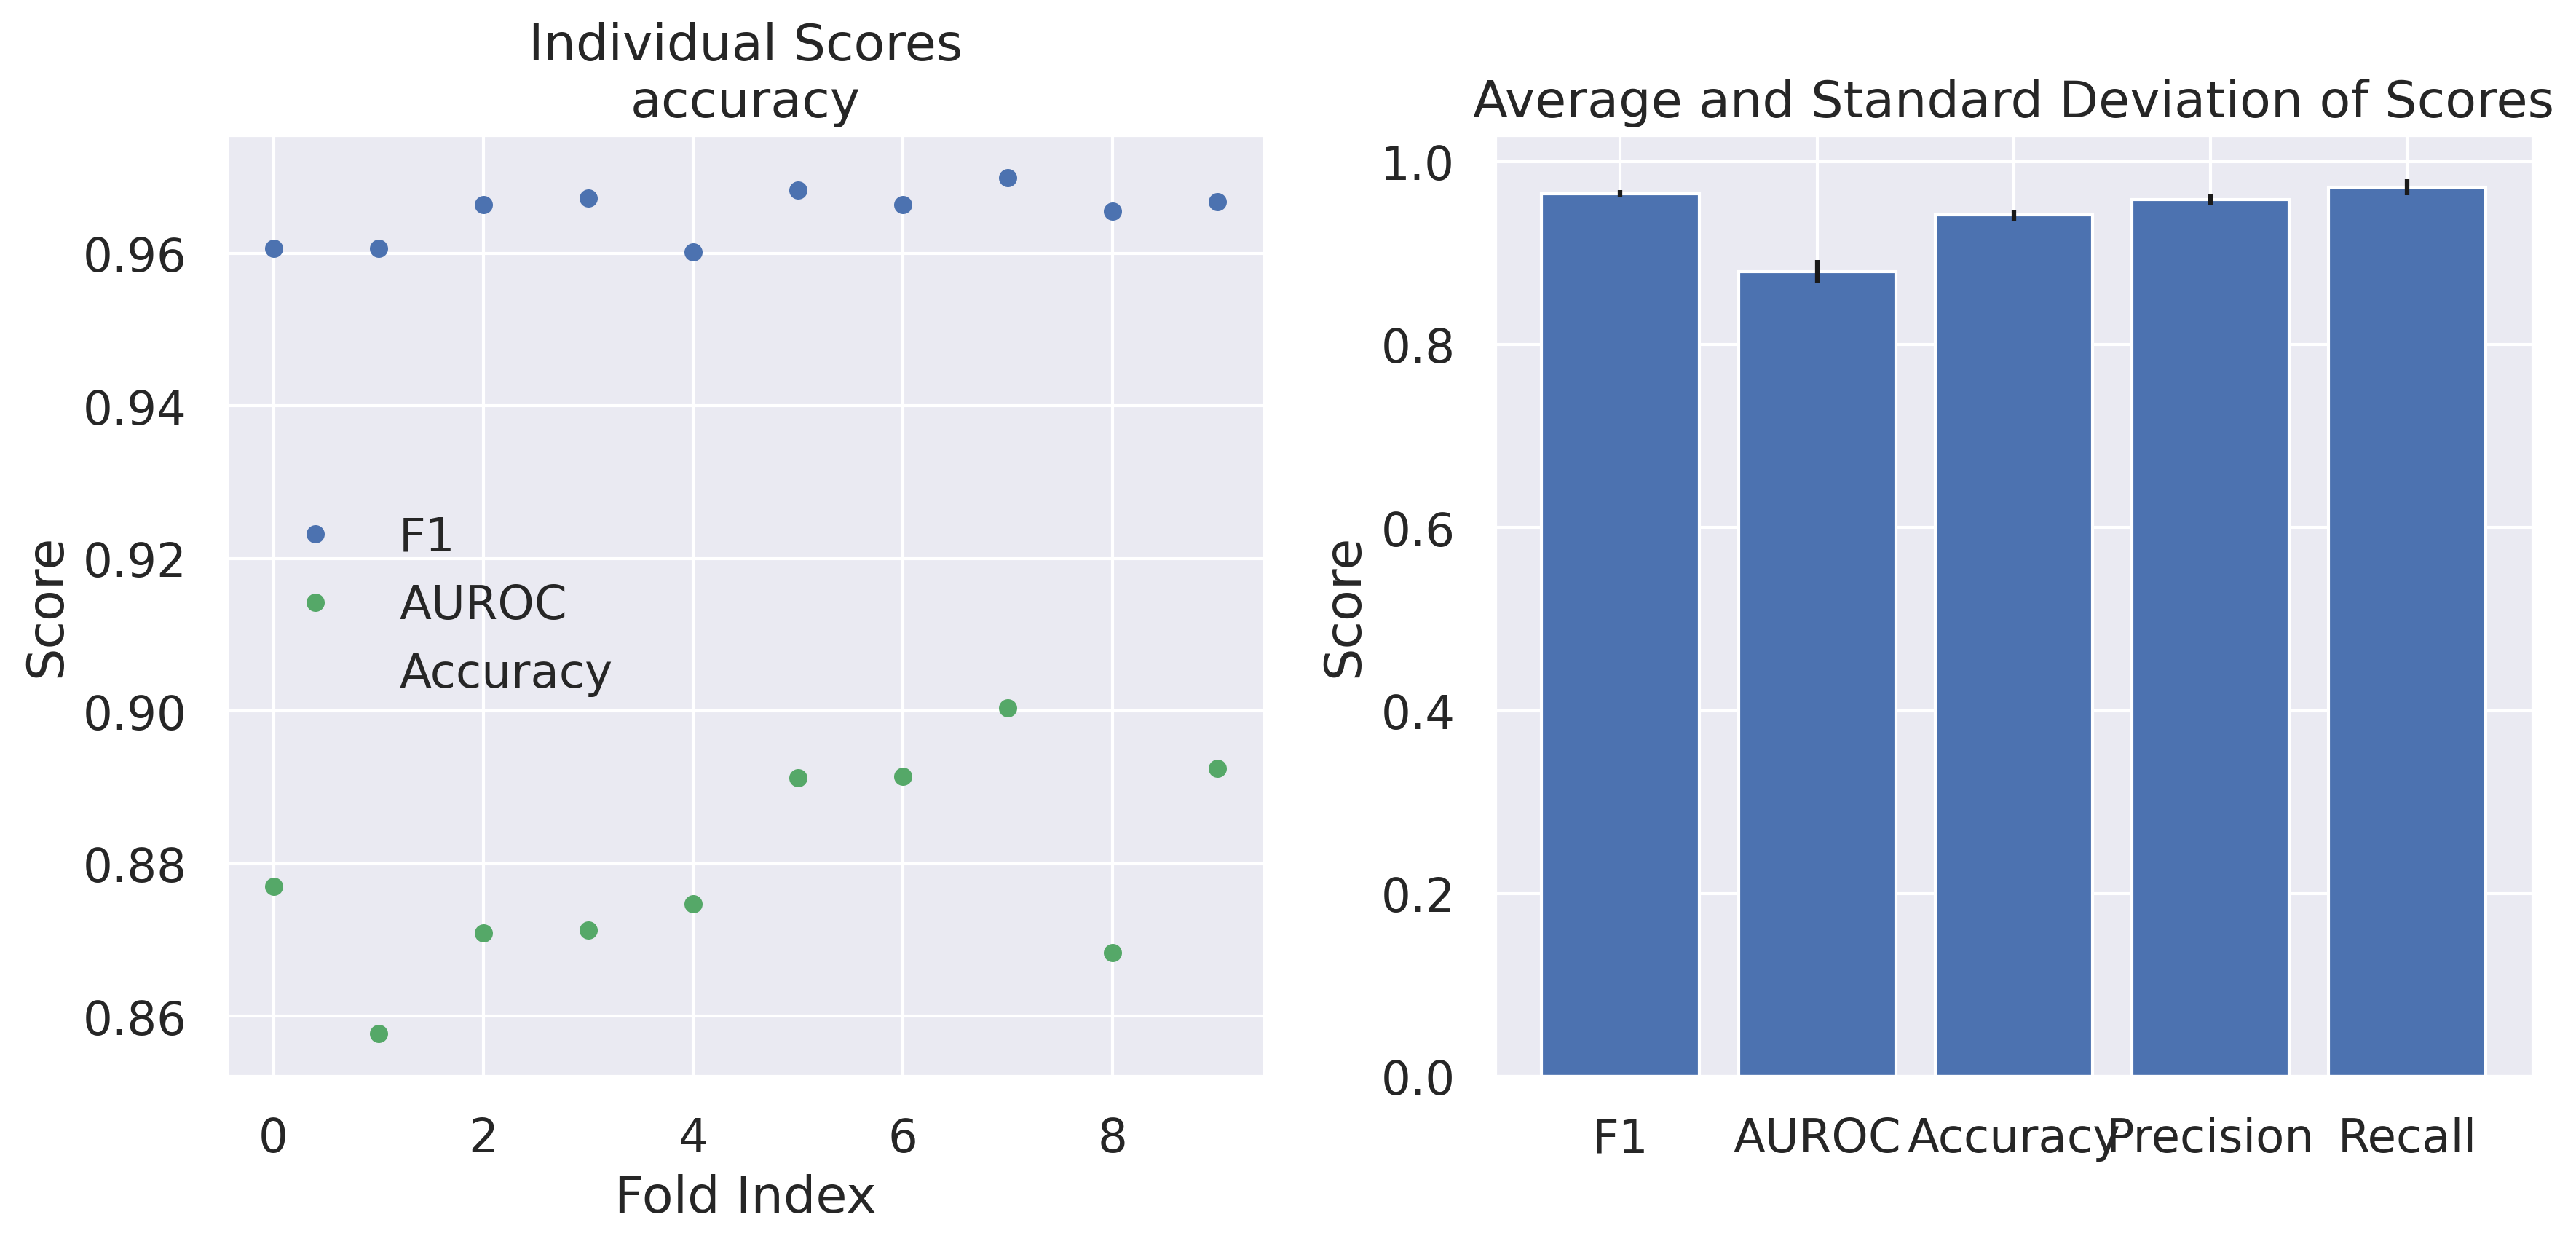

Scorer ran successfully
                              Feature  Importance
0                  Abundance_Controls   27.676424
1                           frac_aa_F    4.418714
2                           frac_aa_L    3.756250
3                     flexibility_min    4.324911
4   fraction_exposed_nonpolar_exposed    5.232316
5        fraction_exposed_polar_total    4.172109
6      fraction_exposed_polar_exposed    4.712770
7                             asa_sum    3.994793
8          fraction_exposed_exposed_M    3.436171
9          fraction_exposed_exposed_P    4.265639
10         fraction_exposed_exposed_S    4.254016
11         fraction_exposed_exposed_Y    3.237404
12      nsp_secondary_structure_sheet    5.861443
13                     Zeta Potential    8.481058
14                               Dtem    4.624706
15                  Dh_functionalized    7.551275


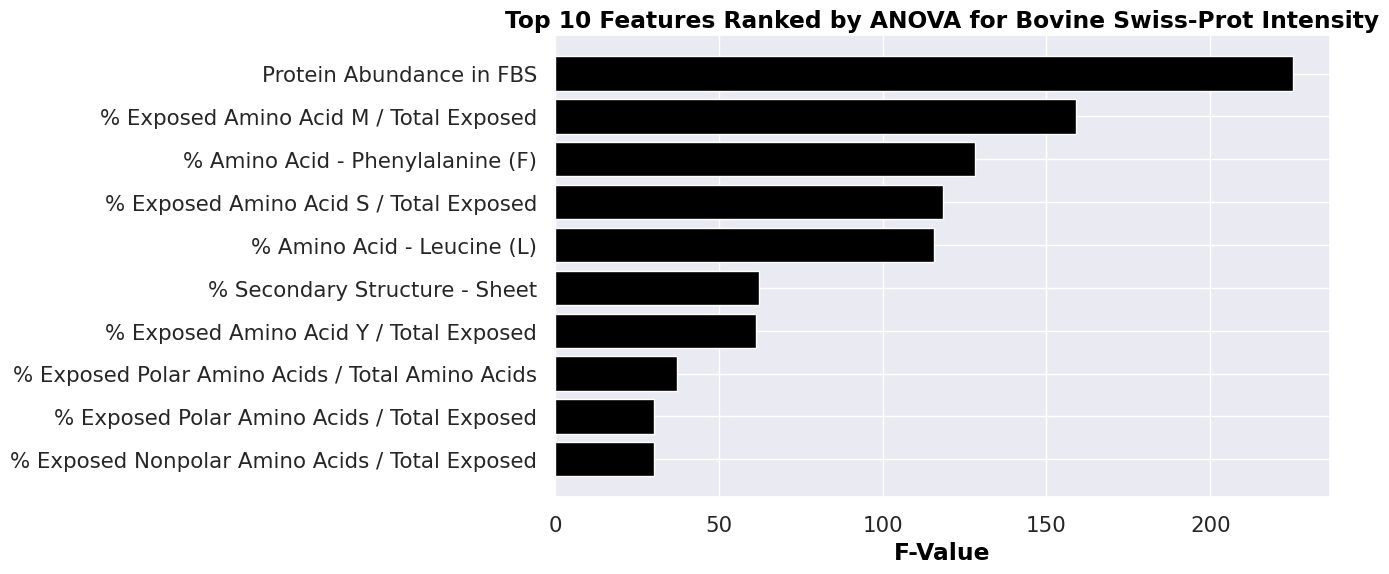

                                            Feature     F-Value       P-Value
0                          Protein Abundance in FBS  225.288308  4.530407e-49
8            % Exposed Amino Acid M / Total Exposed  159.033740  1.604395e-35
1                  % Amino Acid - Phenylalanine (F)  128.029141  4.564942e-29
10           % Exposed Amino Acid S / Total Exposed  118.259794  5.119660e-27
2                        % Amino Acid - Leucine (L)  115.582669  1.872254e-26
12                    % Secondary Structure - Sheet   62.381893  4.003042e-15
11           % Exposed Amino Acid Y / Total Exposed   61.369659  6.620571e-15
5   % Exposed Polar Amino Acids / Total Amino Acids   37.364557  1.113451e-09
6       % Exposed Polar Amino Acids / Total Exposed   30.213622  4.211825e-08
4    % Exposed Nonpolar Amino Acids / Total Exposed   30.213622  4.211825e-08
Results saved to /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFC/df_RFC_RFECV_Bov SP Intensity.csv


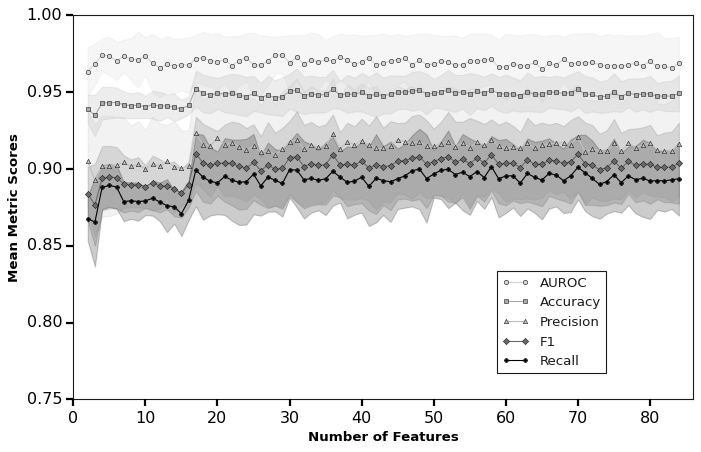

changed thresh from 1 to 0


In [13]:
# Function to process the training file
def process_file(train_df, name):
    # Copy 'binary_target' column to be used as the label for classification
    label_df = train_df['binary_target'].copy()
    y_label = np.ravel(label_df)

    # Remove columns in df that should not be considered as potential features in RFE & RFECV
    columns_to_drop = [col for col in ['Abundance', 'NPUNID', 'Entry', 'Sequence', 'Sample_num', 'Raw_FileID',
                                       'Ligands', 'Enrich', 'binary_target', 'NPID', 'BatchID'] if col in train_df.columns] # added BatchID 2/20/25
    df_original = train_df.copy()
    train_df.drop(columns=columns_to_drop, inplace=True)

    identifier = 'accuracy'
    keep_columns = ['Abundance', 'NPUNID', 'Entry', 'binary_target']

    # Define number of folds for cross-validation
    n_splits = 10
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Initialize RFC model
    model = RandomForestClassifier(n_estimators=100, random_state=42)

    max_features = train_df.shape[1]
    min_features = 1

    current_score = float(-1)
    best_features = None

    df_full_results = pd.DataFrame({
        "Number of features": [],
        "Accuracy": [],
        "Accuracy std": [],
        "Precision": [],
        "Precision std": [],
        "Recall": [],
        "Recall std": [],
        "F1": [],
        "F1 std": [],
        "AUROC": [],
        "AUROC std": [],
        "List of features": [],
        "Combined Score": []
    })

    for n_features in range(max_features, min_features, -1):
        accuracies, precisions, recalls, f1s, aurocs = [], [], [], [], []

        # Make a dictionary with feature name keys
        feat_dict = {key: 0 for key in train_df.columns}

        for train_index, test_index in kf.split(train_df):
            X_train, X_test = train_df.iloc[train_index], train_df.iloc[test_index]
            y_train, y_test = y_label[train_index], y_label[test_index]

            # Train the RFC
            model.fit(X_train, y_train)

            # Get predictions for evaluation
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1]

            # Evaluate on test split
            accuracies.append(model.score(X_test, y_test))
            precisions.append(precision_score(y_test, y_pred, average='macro', zero_division=0))
            recalls.append(recall_score(y_test, y_pred, average='macro', zero_division=0))
            f1s.append(f1_score(y_test, y_pred, average='macro'))
            aurocs.append(roc_auc_score(y_test, y_pred_proba))

            # During each iteration, each feature will get an importance
            for idx, feature in enumerate(train_df.columns):
                feat_dict[feature] += model.feature_importances_[idx]

        # Calculate average of all metrics across all folds
        avg_accuracy, std_accuracy = np.mean(accuracies), np.std(accuracies)
        avg_precision, std_precision = np.mean(precisions), np.std(precisions)
        avg_recall, std_recall = np.mean(recalls), np.std(recalls)
        avg_f1, std_f1 = np.mean(f1s), np.std(f1s)
        avg_auroc, std_auroc = np.mean(aurocs), np.std(aurocs)

        # Record results
        combined_score = avg_accuracy - std_accuracy - (n_features / 5000)
        df_full_results.loc[len(df_full_results)] = {
            'Number of features': n_features,
            'Accuracy': avg_accuracy, 'Accuracy std': std_accuracy,
            'Precision': avg_precision, 'Precision std': std_precision,
            'Recall': avg_recall, 'Recall std': std_recall,
            'F1': avg_f1, 'F1 std': std_f1,
            'AUROC': avg_auroc, 'AUROC std': std_auroc,
            'List of features': ", ".join(train_df.columns),
            'Combined Score': combined_score
        }

        # Drop the feature with the lowest importance sum
        train_df = train_df[[key for key in feat_dict if key != min(feat_dict, key=feat_dict.get)]]

        if combined_score > current_score:
            current_score = combined_score
            best_features = train_df.columns.tolist()



    print("Best Features Names:", best_features)

    # Save RFECV results and scores
    df_full_results.to_csv(f'/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFC/RFECV_RFC_results_{name}_{identifier}.csv', index=False)

    feat_list = best_features + keep_columns
    print(feat_list)

    # Run Scorer function to determine feature importance and metrics for each DataFrame
    df_best = df_original[feat_list].copy()
    output_dir = '/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFC/Bovine Swiss Intensity Training' #
    RFC_Scores, feats = scorer_RFC(df_best[best_features], y_label, model, identifier, 10, output_dir)

    feats.to_excel(f'/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFC/Feats_RFECV_RFC_{name}_{identifier}.xlsx', index=False)
    RFC_Scores.to_excel(f'/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFC/Scores_RFECV_RFC_{name}_{identifier}.xlsx', index=False)

    # Save df with the necessary labeling columns that were previously dropped
    df_RFECV = df_original[feat_list].copy()
    df_RFECV.to_excel(f'/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFC/df_RFECV_RFC_{name}_{identifier}.xlsx', index=False)

    # Feature importance normalization
    feature_importances = model.feature_importances_
    normalized_importances = 100.0 * (feature_importances / feature_importances.sum())
    feature_importance_df = pd.DataFrame({'Feature': best_features, 'Importance': normalized_importances})
    print(feature_importance_df)

    # Rank features by ANOVA
    ranked_features = rank_features_by_anova(df_best[best_features], y_label, best_features)
    top_10_features = ranked_features.head(10)

    # Save the ranked features
    top_10_features.to_csv(f'/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFC/ANOVA_top_features_{name}.csv')

    # Plot top features
    plot_top_features(top_10_features, name)
    print(top_10_features)

    output_file_path = f'/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFC/df_RFC_RFECV_Bov SP Intensity.csv'
    df_full_results.to_csv(output_file_path, index=False)
    print(f'Results saved to {output_file_path}')

    # Plot RFECV results
    plt.style.use('classic')
    fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')

    metrics = ['AUROC', 'Accuracy', 'Precision', 'F1', 'Recall']
    std_metrics = ['AUROC std', 'Accuracy std', 'Precision std', 'F1 std', 'Recall std']
    colors = ['lightgrey', 'darkgrey', 'silver', 'dimgray', 'black']
    markers = ['o', 's', '^', 'D', 'P']

    for metric, std, color, marker in zip(metrics, std_metrics, colors, markers):
        mean_values = df_full_results[metric].values
        std_devs = df_full_results[std].values
        n_features = df_full_results['Number of features'].values

        ax.plot(n_features, mean_values, label=metric, color=color, marker=marker, markersize=4)
        ax.fill_between(n_features, mean_values - std_devs, mean_values + std_devs, color=color, alpha=0.2)

    ax.set_xlabel('Number of Features', fontweight='bold', color='black')
    ax.set_ylabel('Mean Metric Scores', fontweight='bold', color='black')
    ax.set_ylim([0.75, 1.00])
    plt.xlim(left=0, right=86)  # Adjust this limit based on your dataset
    ax.legend(loc='lower right', fontsize='medium', bbox_to_anchor=(0.87, 0.05), borderaxespad=0.5, frameon=True)
    ax.tick_params(axis='both', which='both', direction='out',
                   length=6, width=2, colors='black',
                   labelsize='large', labelcolor='black',
                   bottom=True, top=False, left=True, right=False)
    ax.grid(False)

    plt.savefig(f'/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFC/RFECV_plot_{name}.png')
    plt.savefig(f'/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFC/FECV_plot_{name}.svg')
    plt.show()
    plt.close()

# Call the function with the cleaned training data
train_df = pd.read_excel('/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Input_DataFrames/post_clean_up_dfs/RFC/RFC_converted_df/train_df_Bov SP Intensity_v1.xlsx')
process_file(train_df, "Bov SP Intensity training_data")
print("changed thresh from 1 to 0")

## Predicting on Test Data Split
### Link to previously split testing
Link Excel file from RFECV section: **df_RFECV_RFC_{name}**
to only use features in predictions selected through model training (selected features correspond to columns in df)

Accuracy: 0.9622641509433962
Precision: 0.9520833333333334
Recall: 0.9109848484848485
F1 Score: 0.9299405155320555
AUROC: 0.9857603815937149


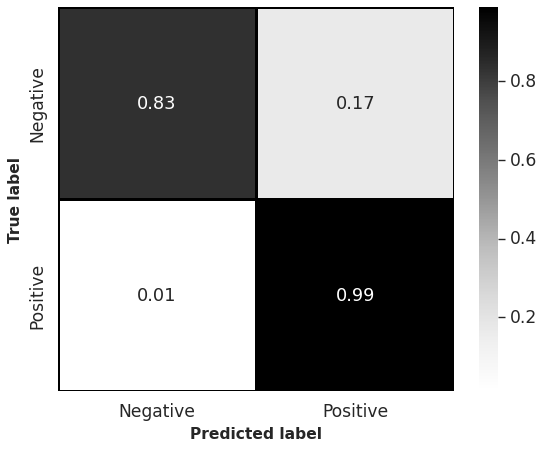

In [15]:
# generated excel file with 'accuracy' in the name
selected_features_df = '/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFC/df_RFECV_RFC_Bov SP Intensity training_data_accuracy.xlsx'

testing_df = '/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Input_DataFrames/post_clean_up_dfs/RFC/RFC_converted_df/test_df_Bov SP Intensity_v1.xlsx'

def plot_confusion_matrix(y_true, y_pred, class_names, name):
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 6))
    plt.gcf().set_facecolor('white')
    sns.set_style('white')
    sns.set(font_scale=1.4)
    sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 16}, fmt=".2f", cmap='Greys',
                xticklabels=class_names, yticklabels=class_names, cbar=True, linewidths=1, linecolor='black')
    plt.ylabel('True label', fontweight='bold', fontsize=14)
    plt.xlabel('Predicted label', fontweight='bold', fontsize=14)
    plt.show()


def predict_file(train_file, test_file, name):
    # Initialize RFC
    model = RandomForestClassifier(n_estimators=100, random_state = 42)

    # Read input dfs
    df_train = pd.read_excel(train_file, header=0)
    df_test = pd.read_excel(test_file, header=0)

    # Define the target variable for training and testing (binary_target)
    y_train = df_train['binary_target'].astype(int)
    y_test = df_test['binary_target'].astype(int)

    # Drop unnecessary columns in both train and test sets
    columns_to_drop = ['Abundance', 'NPUNID', 'Entry', 'binary_target']
    df_train.drop(columns=columns_to_drop, inplace=True, errors='ignore')
    df_test.drop(columns=columns_to_drop, inplace=True, errors='ignore')

    # Ensure the test data has the same features as the training data
    selected_features = df_train.columns.tolist()
    df_test = df_test[selected_features]

    # Train the RFC
    model.fit(df_train, y_train)

    # Predict on the test split
    y_pred = model.predict(df_test)
    y_pred_proba = model.predict_proba(df_test)

    # Evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro')
    auroc = roc_auc_score(y_test, y_pred_proba[:, 1]) if len(np.unique(y_test)) == 2 else roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

    # Print evaluation metrics
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("AUROC:", auroc)

    # Plot CM
    plot_confusion_matrix(y_test, y_pred, ['Negative', 'Positive'], name)

    # Save evaluation metrics to an Excel file
    metrics = {
        "Accuracy": [accuracy],
        "Precision": [precision],
        "Recall": [recall],
        "F1 Score": [f1],
        "AUROC": [auroc]
    }
    metrics_df = pd.DataFrame(metrics)
    #metrics_df.to_excel(f'/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFC/Metrics_{name}_bootstrapped_retain_zeros.xlsx', index=False)


predict_file(selected_features_df, testing_df, 'Bov SP Intensity')
